In [1]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import zipfile as zipfile
import shutil
import random
from pathlib import Path

from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
files = zipfile.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['glass', 'trash', 'plastic', '.DS_Store', 'metal', 'cardboard', 'paper']

In [ ]:
#returns a split between test, valid, and train indices for the input folder
def splitDataIndices(folder,trainSplit):    
    n = len(os.listdir(folder))
    fullSet = list(range(1,n+1))

    #train indices
    random.seed()
    train = random.sample(list(range(1,n+1)),int(trainSplit*n))
    remain = list(set(fullSet)-set(train))

    #rest of the data is split between valid and test
    random.seed()
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return (train,valid,test)

In [ ]:
#get file names for the given indices
def getNames(trashType, indices):
    names = [f"{trashType}{str(i)}.jpg" for i in indices]
    return(names)    

#moves source files to destination folder
def moveFiles(sourceFiles,destination):
    for f in sourceFiles:
        shutil.move(f,destination)

In [ ]:
subsets = ['train','valid']
trashTypes = ['cardboard','plastic','glass','metal','paper','trash']

#create destination folders for data subset and waste type
for subset in subsets:
    for trash in trashTypes:
        folder = os.path.join('data',subset,trash)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
#move files to destination folders for each trash type
for trash in trashTypes:
    fullDataFolder = os.path.join('dataset-resized',trash)
    traini, validi, testi = splitDataIndices(fullDataFolder,0.5)
    
    trainNames = getNames(trash,traini)
    train_source_files = [os.path.join(fullDataFolder,name) for name in trainNames]
    moveFiles(train_source_files,"data/train/"+trash)
    
    validNames = getNames(trash,validi)
    valid_source_files = [os.path.join(fullDataFolder,name) for name in validNames]
    moveFiles(valid_source_files,"data/valid/"+trash)
    
    testNames = getNames(trash,testi)
    test_source_files = [os.path.join(fullDataFolder,name) for name in testNames]
    moveFiles(test_source_files,"data/test")

In [2]:
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [3]:
tfms = get_transforms()
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

AssertionError: ignored

In [ ]:
print(data)
print(data.classes)

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
learner = cnn_learner(data,models.resnet101,metrics=error_rate)

RuntimeError: ignored

In [ ]:
learner.lr_find(start_lr=1e-6,end_lr=1e1)
learner.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

In [ ]:
#find optimum learning rate
lr_diff = 15
loss_threshold = .05 
adjust_value = 1
plot = False
lrs = learner.recorder.lrs
losses = np.array(learner.recorder.losses)
assert(lr_diff < len(losses))
loss_grad = np.gradient(losses)

r_idx = -1
l_idx = r_idx - lr_diff
while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
    local_min_lr = lrs[l_idx]
    r_idx -= 1
    l_idx -= 1

lr_to_use = local_min_lr * adjust_value
print(lr_to_use)

0.004365158322401661


In [ ]:
learner.fit_one_cycle(30,max_lr=lr_to_use)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

In [ ]:
learner.export('models/fastai_2.pkl')

In [ ]:
learner = load_learner('data/models', 'fastai_1.pkl')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data\models;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data\models;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

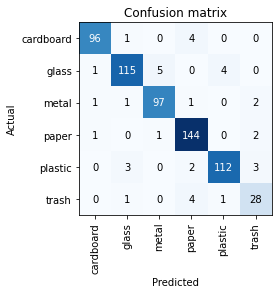

In [ ]:
#confusion matrix
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()